In [1]:
import subprocess
import pybedtools
from biodata.delimited import DelimitedWriter
from biodata.gff import GTFReader
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from pathlib import Path

In [2]:
matplotlib.font_manager.fontManager.addfont(f"{Path.cwd().parent}/font/Arial.ttf")
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12

In [3]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"

# Make genomic bins

In [5]:
# Divide genomes into bins 

def make_windows(chrom_sizes, bin_size, outputfile):
	commands = ["bedtools makewindows",
				 "-g", chrom_sizes,
				 "-w", bin_size,
				 ">", outputfile
				]
	subprocess.run(" ".join(commands), shell=True)

In [6]:
bin_size = "50000"
chrom_sizes = f"{PROJECT_DIR_r}genomes/human/hg38.chrom.sizes.filtered.no.chrY"
bin_file = f"{PROJECT_DIR_o}temp/genome_windows.bed"
make_windows(chrom_sizes, bin_size, bin_file)

# Distribution of elements in bins

## TREs

In [4]:
# Only focus on distal elements

s = "C1"
d = "distal"
ps = ["divergent", "unidirectional"]

In [7]:
overlaps = {}
b1 = pybedtools.BedTool(bin_file)
for p in ps:
	b2 = pybedtools.BedTool(f"{PROJECT_DIR_d}bed_plot/{s}_{p}_{d}.bed")
	# F: Minimum overlap required as a fraction of B.
	overlap = b1.intersect(b2, u=True, F=0.5)
	overlaps[p] = [tuple(i.fields[:3]) for i in overlap]

## Genes

In [9]:
inputfile = f"{PROJECT_DIR_r}genomes/human/gencode.v37.annotation.gtf.gz"
outputfile = f"{PROJECT_DIR_r}genomes/human/gencode.v37.gene_pos.bed"
with DelimitedWriter(outputfile) as dw:
	with GTFReader(inputfile) as gr:
		for gff in gr:
			if gff.feature == "gene":
				dw.write([gff.genomic_pos.name, gff.genomic_pos.start, gff.genomic_pos.stop])

In [10]:
subprocess.run("gzip -f " + outputfile, shell=True)

CompletedProcess(args='gzip -f /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/genomes/human/gencode.v37.gene_pos.bed', returncode=0)

In [8]:
b2 = pybedtools.BedTool(f"{PROJECT_DIR_r}genomes/human/gencode.v37.gene_pos.bed.gz")
overlap = b1.intersect(b2, u=True, F=0.5)
overlaps["gene"] = [tuple(i.fields[:3]) for i in overlap]

# Plot distribution across the genome

## Generate legend

In [9]:
colors = {
    "divergent": "#08306b",
    "unidirectional": "#ae017e", 
    "gene": "#41ab5d"
}

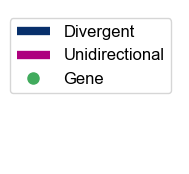

In [19]:
fig, ax = plt.subplots(figsize=(2, 2))
handles = []
for k in colors:
	if k == "gene":
		handle = Line2D([0], [0], marker="o", linestyle='None', color=colors[k], 
		               markerfacecolor=colors[k], markersize=8)
	else:
		handle = Line2D([0], [0], color=colors[k],
			    linewidth=6, solid_capstyle='butt')
	handles.append(handle)
	
legend = ax.legend(handles, 
                   [k.capitalize() for k in colors], 
                   fontsize=bfontsize)
ax.set_axis_off()

outputfile = f"{PROJECT_DIR_o}figures/ExtDataFig6.legend.pdf"
plt.savefig(outputfile, bbox_inches="tight", transparent=True)

## Prepare input

In [14]:
# https://github.com/jordanlab/tagore

In [10]:
# feature: The shape of the feature (0: a rectangle; 1: a circle)
# size: The horizontal size of the feature (range between 0 and 1)
# color: Specify the color of the genomic feature with a hex value
# chrCopy: Specify the chromosome copy on which the feature should be drawn (1 or 2). To draw the same feature on both chromosomes, you must specify the feature twice

# TREs
feature1 = 0
size1 = 1
# Genes
feature2 = 1
size2 = 0.02

outputfile = f"{PROJECT_DIR_o}temp/genomic_distribution.bed"
with DelimitedWriter(outputfile) as dw:
	dw.write(["#chr", "start", "stop", "feature", "size", "color", "chrCopy"])
	# TREs
	for p in ps:
		if p == "divergent":
			chrCopy = 1
		else:
			chrCopy = 2
		# TREs
		for chrom, start, end in overlaps[p]:
			dw.write([chrom, start, end, feature1, size1, colors[p], chrCopy])
		# Genes
		for chrom, start, end in overlaps["gene"]:
			dw.write([chrom, start, end, feature2, size2, colors["gene"], chrCopy])

In [11]:
# output both png and svg format

def plot_genomes(inputfile, output_prefix):
	commands = ["tagore",
				 "-i", inputfile,
				 "-p", output_prefix,
				 "-b", "hg38",
				 # Overwrite output files if they exist already
				 "-f"
				]
	subprocess.run(" ".join(commands), shell=True)

In [12]:
inputfile = f"{PROJECT_DIR_o}temp/genomic_distribution.bed"
output_prefix = f"{PROJECT_DIR_o}figures/ExtDataFig6"
plot_genomes(inputfile, output_prefix)